# Structural data exploration

Data exploration of ADNI patients. The data consists of europsychological assesments carried out for each patient.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from scipy.stats import kruskal, pearsonr
from os.path import exists
from decimal import Decimal

np.random.seed(0)
COMBAT = False

### BrainAge Modelling

Create a model that given features extracted from brain images correctly predicts a patients age in control subjects.

In [2]:
# Load dataframe
if not COMBAT:
    fname = 'adni_full_data'
else:
    fname = 'adni_full_data_for_homogenisation'
    
df_full = pd.read_csv('../DATA/%s.csv' % fname, index_col=0)

# Mark features to use
features = ['MMSCORE', 'ADASSCORE', 'FAQTOTAL', 'MOCASCORE', 'ADNI_MEM', 'ADNI_EF']

# Exctract controls that haven't converted
df_cn = df_full[df_full['TYPECONVERSOR']==1.0]

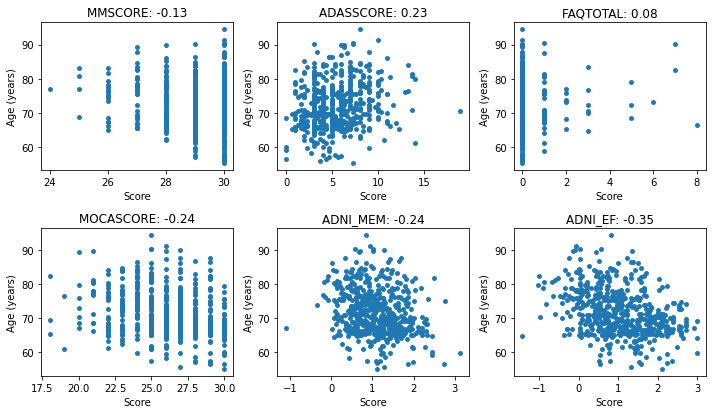

In [3]:
# Explore relationship between each individual feature and age.
X = df_cn[features].to_numpy()
Y = df_cn['AGE'].to_numpy()

plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X[:,d],Y,s=15)
    pearson_coeff, _ = pearsonr(X[:, d], Y)
    plt.xlabel('Score')
    plt.ylabel('Age (years)')
    plt.title("{0}: {1:.2f}".format(features[d],pearson_coeff))
plt.tight_layout()

There are some features that weakly linearly related with our dependent variable.

In [4]:
# Generate train and test partitions
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=0)

# Data normalization
transformer = StandardScaler().fit(X_train)  # fit() learns mean and std parameters
X_train_norm = transformer.transform(X_train) # transform() normalizes
X_test_norm =  transformer.transform(X_test)

MAE in test: 4.507691


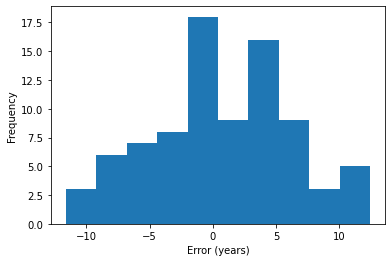

In [5]:
LR_brainage = LinearRegression(fit_intercept='True')
# Train the model
LR_brainage.fit(X_train_norm, Y_train)

# Compute the predictions over test data
f_test = LR_brainage.predict(X_test_norm)
delta_cn = f_test - Y_test
MAE_test = np.mean(np.abs(delta_cn))
print('MAE in test: %f' % MAE_test)
plt.xlabel('Error (years)')
plt.ylabel('Frequency')
plt.hist(delta_cn)
plt.show()

A poor MAE is achieved but better than using the mean as our age estimate which would yield a 4.9 MAE. Although the neuropsych tests are not amazing indicators of age they do contain some information.

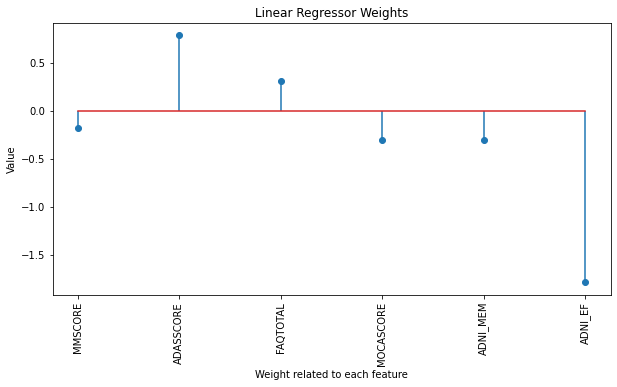

In [6]:
# Linear regressor weights as a measure of importance
LR_weights = LR_brainage.coef_

# Plot weights
plt.figure(figsize=(10,5))
plt.title('Linear Regressor Weights')
plt.stem(features, LR_weights)
plt.xticks(rotation='vertical')
plt.xlabel('Weight related to each feature')
plt.ylabel('Value')
plt.show()

All neuropsychological tests seem to contribute to help estimate age.

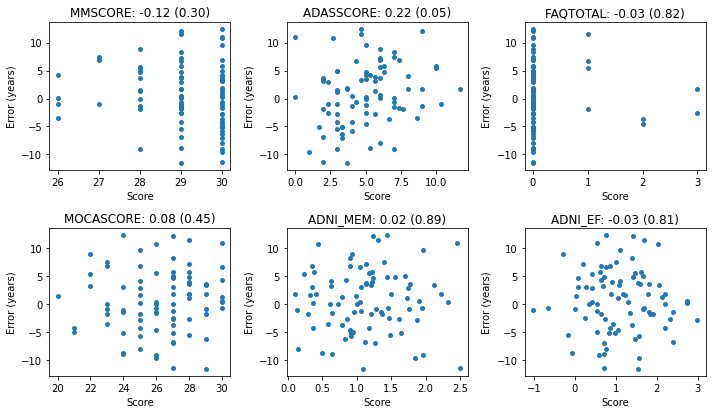

In [7]:
# Explore if there is any correlation between features and delta in controls
plt.figure(figsize=(10,14))
for d in range (len(features)):
    plt.subplot(5,3,d+1)
    plt.scatter(X_test[:,d], delta_cn,s=15)
    plt.xlabel('Score')
    plt.ylabel('Error (years)')
    pearson_coeff, pval = pearsonr(X_test[:, d], delta_cn)
    plt.title("{0}: {1:.2f} ({2:.2f})".format(features[d],pearson_coeff,pval))
plt.tight_layout()

As expected there is no direct correaltion between brain deltas in controls and the features.

We correct for the age bias, which in this case is even more pronounced as our age estimates our worse.

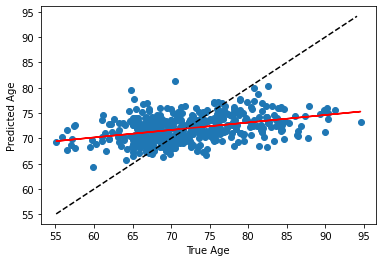

In [8]:
# Explore relationship between age and delta
f_train = LR_brainage.predict(X_train_norm)
LR_age_bias = LinearRegression(fit_intercept='True')
LR_age_bias.fit(Y_train.reshape(-1, 1), f_train)
age_range = np.arange(np.min(Y_train), np.max(Y_train))
plt.plot(age_range, age_range, color='k', linestyle='dashed')
plt.plot(Y_train, LR_age_bias.predict(Y_train.reshape(-1,1)), color='r')
plt.scatter(Y_train, f_train)
plt.ylabel('Predicted Age')
plt.xlabel('True Age')
plt.show()

However, this can be fixed by adjusting the predicted BrainAge taking into account the actual age of the patient to correct for this bias, as shown below:

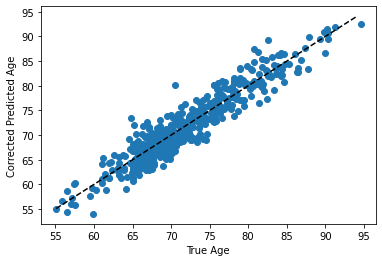

In [9]:
f_train_no_bias = f_train + (Y_train-LR_age_bias.predict(Y_train.reshape(-1, 1)))
plt.scatter(Y_train, f_train_no_bias)
plt.plot(age_range, age_range, color='k', linestyle='dashed')
plt.ylabel('Corrected Predicted Age')
plt.xlabel('True Age')
plt.show()

MAE in test: 1.799343


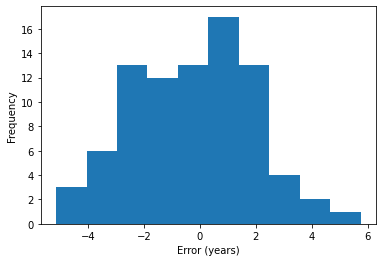

In [10]:
# Compute the predictions over test data with bias correction
f_test = LR_brainage.predict(X_test_norm)
f_test_no_bias = f_test + (Y_test-LR_age_bias.predict(Y_test.reshape(-1, 1)))
delta_cn = f_test_no_bias - Y_test
MAE_test = np.mean(np.abs(delta_cn))
print('MAE in test: %f' % MAE_test)
plt.xlabel('Error (years)')
plt.ylabel('Frequency')
plt.hist(delta_cn)
plt.show()

### Analysis of brain deltas

An exploration of the difference between the predicted age by the model and the real age of participants, which we call the brain delta. The model is trained on healthy controls so we expect that MCI and AD patients might have significantly different deltas.

In [11]:
Y = df_full[features].to_numpy()
X_norm = transformer.transform(Y)
age = df_full['AGE'].to_numpy()
df_full['NeuroBrainAge'] = LR_brainage.predict(X_norm) + (age-LR_age_bias.predict(age.reshape(-1,1)))
df_full['NeuroBrainDelta'] = df_full['NeuroBrainAge']-df_full['AGE']

if not COMBAT:
    fname = 'adni_brainage'
else:
    fname = 'adni_brainage_homogenisation'

if exists('../DATA/%s.csv' % fname):
    df_brainages = pd.read_csv('../DATA/%s.csv' % fname, index_col=0)
    if 'NeuroBrainAge' in df_brainages:
        df_brainages.drop(['NeuroBrainAge', 'NeuroBrainDelta'], axis=1, inplace=True)
else:
    df_brainages = pd.DataFrame(df_full[['RID', 'TYPECONVERSOR']].copy(), columns=['RID', 'TYPECONVERSOR'])
df_brainages = df_brainages.merge(df_full[['RID', 'NeuroBrainAge', 'NeuroBrainDelta']], on=['RID'])
df_brainages.to_csv('../DATA/%s.csv' % fname)

In [12]:
# Cohen's d size: 0.01 Very small, 0.2 Small, 0.5 Medium, 0.8 Large, 1.2 Very large, 2.0 Huge
def cohen_d(x,y):
        return (np.mean(x) - np.mean(y)) / np.sqrt((np.std(x, ddof=1) ** 2 + np.std(y, ddof=1) ** 2) / 2.0)

Brain delta mean for
CN: -0.206276 (2.192836)
MCI: 4.428330 (3.953379)
AD: 16.075250 (6.357550)
Brain delta median for
CN: -0.147738
MCI: 3.828113
AD: 15.320842
p-value
CN vs MCI: 8.443035e-26
CN vs AD: 8.443035e-26
MCI vs AD: 6.934446e-83
Cohens d
CN vs MCI: -1.446891
CN vs AD: -3.414280
MCI vs AD: 2.195822


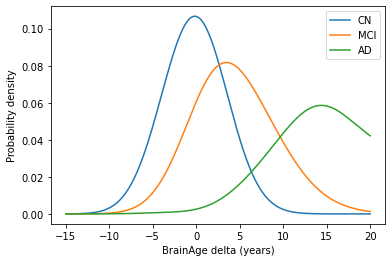

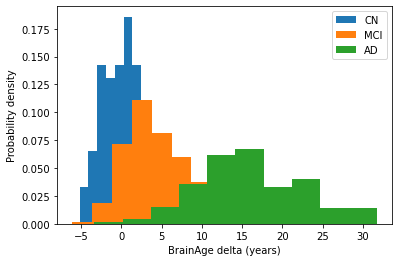

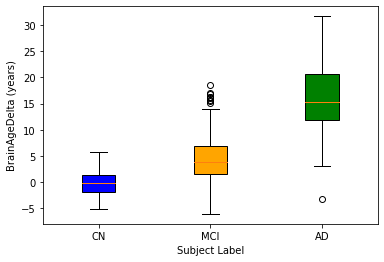

In [13]:
# Explore difference between CN, MCI and AD deltas
df_mci = df_full[df_full['DIAGNOSIS']==2.0]
df_ad = df_full[df_full['DIAGNOSIS']==3.0]

# Make estimations
delta_mci = df_mci['NeuroBrainDelta'].to_numpy()
delta_ad = df_ad['NeuroBrainDelta'].to_numpy()

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f (%f)' % (np.mean(delta_cn), np.std(delta_cn)))
print('MCI: %f (%f)' % (np.mean(delta_mci), np.std(delta_mci)))
print('AD: %f (%f)' % (np.mean(delta_ad), np.std(delta_ad)))
print('Brain delta median for')
print('CN: %f' % np.median(delta_cn))
print('MCI: %f' % np.median(delta_mci))
print('AD: %f' % np.median(delta_ad))

# Calculate p-value
print('p-value')
hstat_cnvsmci, pval_cnvsmci = kruskal(delta_cn, delta_mci)
hstat_cnvsad, pval_cnvsad = kruskal(delta_cn, delta_mci)
hstat_mcivsad, pval_mcivsad = kruskal(delta_ad, delta_mci)
print('CN vs MCI: %e' % Decimal(pval_cnvsmci))
print('CN vs AD: %e' % Decimal(pval_cnvsad))
print('MCI vs AD: %e' % Decimal(pval_mcivsad))

# Calculate cohen's d size
print('Cohens d')
cohend_cnvsmci = cohen_d(delta_cn, delta_mci)
cohend_cnvsad = cohen_d(delta_cn, delta_ad)
cohend_mcivsad = cohen_d(delta_ad, delta_mci)
print('CN vs MCI: %f' % cohend_cnvsmci)
print('CN vs AD: %f' % cohend_cnvsad)
print('MCI vs AD: %f' % cohend_mcivsad)

# Plot kernel density estimates for samples
from sklearn.neighbors import KernelDensity
X_plot = np.linspace(-15, 20, 1000)[:, np.newaxis]
kde_cn = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='AD')
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_cn, label='CN', density=True)
plt.hist(delta_mci, label='MCI', density=True)
plt.hist(delta_ad, label='AD', density=True)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot boxplots
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot([delta_cn, delta_mci, delta_ad], patch_artist = True,
                labels=['CN', 'MCI', 'AD'])
colors = ['b', 'orange',
          'g']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Subject Label')
plt.ylabel('BrainAgeDelta (years)')
plt.show()

As expected there is a clear difference in brain age deltas between CN, MCI and AD. Even more compared to the brainAge based on brain structural data.

### Analysis of conversors

Analyse the value of brain delta as a biomarker for conversors. That is either CN that progress to MCI and also MCI that progress to AD.

p-value of age distributions
CN vs CN2MCI: 0.003638
Brain delta mean for
CN: -0.206276
CN2MCI: 1.770965
Brain delta median for
CN: -0.147738
CN2MCI: 1.537428
p-value
CN vs CN2MCI: 0.000011
Cohens d
CN vs CN2MCI: -0.821730


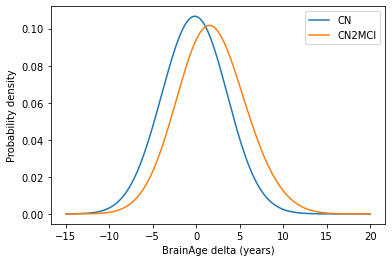

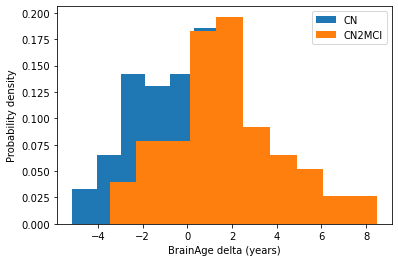

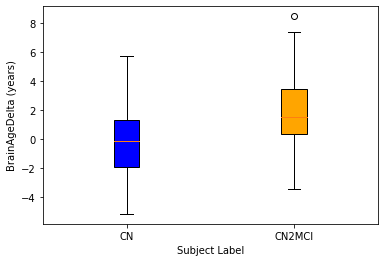

In [14]:
# Explore differences between CN and CN2MCI conversors
df_cn2mci = df_full[df_full['TYPECONVERSOR']==4.0]
delta_cn2mci = df_cn2mci['NeuroBrainDelta'].to_numpy()

# Check p-values between groups for age not different
mci_age_noconv = df_cn['AGE'].to_numpy()
mci_age_conv = df_cn2mci['AGE'].to_numpy()
print('p-value of age distributions')
hstat_noconvvsconv_age, pval_noconvvsconv_age = kruskal(mci_age_noconv, mci_age_conv)
print('CN vs CN2MCI: %f' % pval_noconvvsconv_age)

# Obtain mean and medians for each
print('Brain delta mean for')
print('CN: %f' % np.mean(delta_cn))
print('CN2MCI: %f' % np.mean(delta_cn2mci))
print('Brain delta median for')
print('CN: %f' % np.median(delta_cn))
print('CN2MCI: %f' % np.median(delta_cn2mci))

# Calculate p-value
print('p-value')
hstat_cn2mci, pval_cn2mci = kruskal(delta_cn, delta_cn2mci)
print('CN vs CN2MCI: %f' % pval_cn2mci)

# Calculate cohen's d size
print('Cohens d')
cohend_cn2mci = cohen_d(delta_cn, delta_cn2mci)
print('CN vs CN2MCI: %f' % cohend_cn2mci)

# Plot kernel densities
kde_cn = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn[:, np.newaxis])
log_dens_cn = kde_cn.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_cn), label='CN')
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_cn2mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='CN2MCI')
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histogram
plt.hist(delta_cn, label='CN', density=True)
plt.hist(delta_cn2mci, label='CN2MCI', density=True)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot boxplots
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot([delta_cn, delta_cn2mci], patch_artist = True,
                labels=['CN', 'CN2MCI'])
colors = ['b', 'orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Subject Label')
plt.ylabel('BrainAgeDelta (years)')
plt.show()

Similar to structural data there is a slight difference between CN and CN2MCI subjects. 

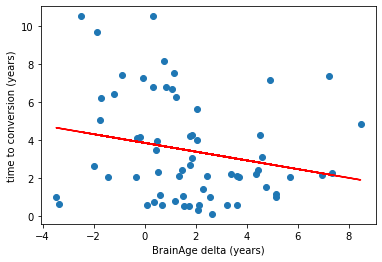

Model metrics:
R^2: 0.047165
Pearson coeff (p-value): -0.217176 (0.084743)


In [15]:
# Explore relationship between conversion time and brain delta for CN2MCI

# Plot linear regression
times = df_cn2mci['TIME2CONVERSION'].to_numpy()
LR_cn2mci = LinearRegression()
LR_cn2mci.fit(delta_cn2mci.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_cn2mci.predict(delta_cn2mci.reshape(-1, 1))
 
# predicted values
plt.plot(delta_cn2mci, predicted_times, color='r')
plt.scatter(delta_cn2mci, times)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, delta_cn2mci)
print('Pearson coeff (p-value): %f (%f)' % (pearson_coeff, pval))

Altough there is a high pearson coefficient than with structural data this is still non-significant (p-value greater than 0.05)

p-value of age distributions
MCI vs MCI2AD: 0.089544
Brain delta mean for
MCI: 3.793878
MCI2AD: 7.471827
Brain delta median for
MCI: 3.477638
MCI2AD: 7.162707
p-value
MCI vs MCI2AD: 0.000000
Cohens d
MCI vs MCI2AD: -0.997526


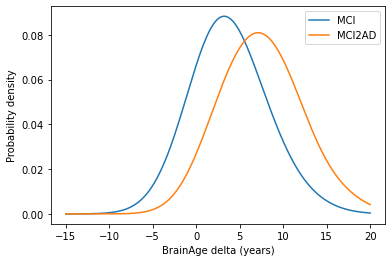

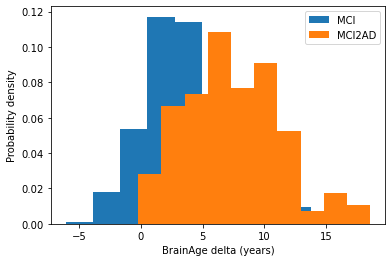

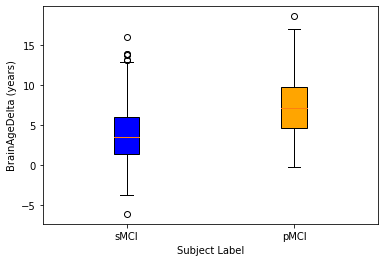

In [16]:
# Explore differences between MCI and CN2MCI conversors
df_mci = df_full[df_full['TYPECONVERSOR']==2.0]
df_mci2ad = df_full[df_full['TYPECONVERSOR']==5.0]
delta_mci2ad = df_mci2ad['NeuroBrainDelta'].to_numpy()
delta_mci = df_mci['NeuroBrainDelta'].to_numpy()

# Check p-values between groups for age not different
mci_age_noconv = df_mci['AGE'].to_numpy()
mci_age_conv = df_mci2ad['AGE'].to_numpy()
print('p-value of age distributions')
hstat_noconvvsconv_age, pval_noconvvsconv_age = kruskal(mci_age_noconv, mci_age_conv)
print('MCI vs MCI2AD: %f' % pval_noconvvsconv_age)

# Obtain mean and medians for each
print('Brain delta mean for')
print('MCI: %f' % np.mean(delta_mci))
print('MCI2AD: %f' % np.mean(delta_mci2ad))
print('Brain delta median for')
print('MCI: %f' % np.median(delta_mci))
print('MCI2AD: %f' % np.median(delta_mci2ad))

# Calculate t-test
print('p-value')
hstat_mci2ad, pval_mci2ad = kruskal(delta_mci, delta_mci2ad)
print('MCI vs MCI2AD: %f' % pval_mci2ad)

# Calculate cohen's d size
print('Cohens d')
cohend_mci2ad = cohen_d(delta_mci, delta_mci2ad)
print('MCI vs MCI2AD: %f' % cohend_mci2ad)

# Plot kernel density estimates
kde_mci = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci[:, np.newaxis])
log_dens_mci = kde_mci.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
kde_ad = KernelDensity(kernel="gaussian", bandwidth=3).fit(delta_mci2ad[:, np.newaxis])
log_dens_ad = kde_ad.score_samples(X_plot)
plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot histograms
plt.hist(delta_mci, label='MCI', density=True)
plt.hist(delta_mci2ad, label='MCI2AD', density=True)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('Probability density')
plt.legend()
plt.show()

# Plot boxplots
fig = plt.figure()
ax = fig.add_subplot(111)
bp = ax.boxplot([delta_mci, delta_mci2ad], patch_artist = True,
                labels=['sMCI', 'pMCI'])
colors = ['b', 'orange']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
plt.xlabel('Subject Label')
plt.ylabel('BrainAgeDelta (years)')
plt.show()

There difference between MCI and MCI2AD conversros in terms of their brain age deltas is even bigger than with structural data.

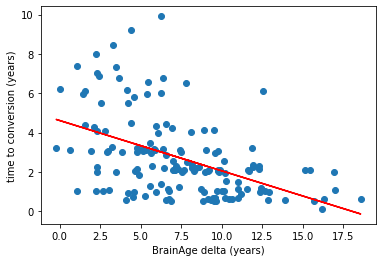

Model metrics:
R^2: 0.233904
Pearson coeff (p-value): -0.483637 (2.760358e-10)


In [17]:
# Explore relationship between conversion time and brain delta for MCI2AD

# Plot linear regression
times = df_mci2ad['TIME2CONVERSION'].to_numpy()
LR_mci2ad = LinearRegression()
LR_mci2ad.fit(delta_mci2ad.reshape(-1, 1), times.reshape(-1, 1))
predicted_times = LR_mci2ad.predict(delta_mci2ad.reshape(-1, 1))
 
# predicted values
plt.plot(delta_mci2ad, predicted_times, color='r')
plt.scatter(delta_mci2ad, times)
plt.xlabel('BrainAge delta (years)')
plt.ylabel('time to conversion (years)')
plt.show()

print('Model metrics:')
print('R^2: %f' % metrics.r2_score(times, predicted_times))
pearson_coeff, pval = pearsonr(times, delta_mci2ad)
print('Pearson coeff (p-value): %f (%e)' % (pearson_coeff, Decimal(pval)))

The correlation between deltas and time to conversion is also stronger than with structural data. Also it should be noted that all subjects are given brain deltas greater than zero.

In [18]:
# Explore relationship between features and conversors and non-conversors
features_mci = df_mci[features].to_numpy()
features_mci2ad = df_mci2ad[features].to_numpy()
bonferroni_corrected_val = 0.05/len(features)
print('p-value MCI vs MCI2AD (<%f)'%bonferroni_corrected_val)
significant_features = []
for d in range(len(features)):
    hstat_mci2ad, pval_mci2ad = kruskal(features_mci[:, d], features_mci2ad[:, d])
    print('%s: %f' % (features[d], pval_mci2ad))
    if pval_mci2ad < bonferroni_corrected_val:
        significant_features.append(d)

p-value MCI vs MCI2AD (<0.008333)
MMSCORE: 0.000000
ADASSCORE: 0.000000
FAQTOTAL: 0.000000
MOCASCORE: 0.000000
ADNI_MEM: 0.000000
ADNI_EF: 0.000000


As expected all neuropsychological test are good indicator of conversion since they were designed for this purpose.

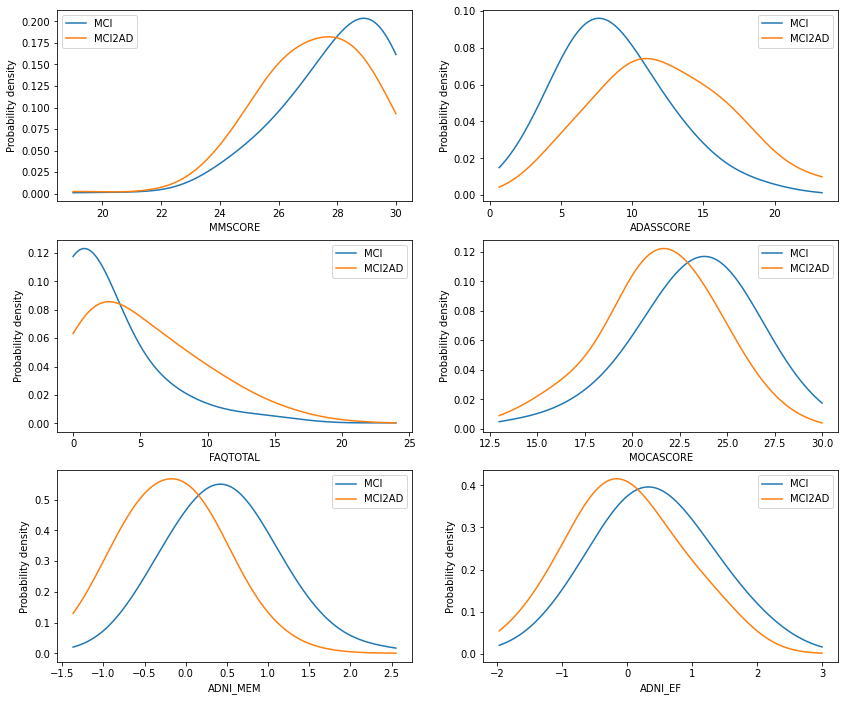

In [19]:
plt.figure(figsize=(14,12))
for i, f in enumerate(significant_features):
    plt.subplot(3,2,i+1)
    min_val, max_val = np.min(features_mci[:, f]), np.max(features_mci[:, f])
    range_vals = max_val - min_val
    X_plot = np.linspace(min_val, max_val, 1000)[:, np.newaxis]
    # Plot kernel density estimates
    kde_mci = KernelDensity(kernel="gaussian", bandwidth=range_vals/10).fit(features_mci[:, f].reshape(-1, 1))
    log_dens_mci = kde_mci.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens_mci), label='MCI')
    kde_ad = KernelDensity(kernel="gaussian", bandwidth=range_vals/10).fit(features_mci2ad[:, f].reshape(-1, 1))
    log_dens_ad = kde_ad.score_samples(X_plot)
    plt.plot(X_plot[:, 0], np.exp(log_dens_ad), label='MCI2AD')
    plt.xlabel(features[f])
    plt.ylabel('Probability density')
    plt.legend()
plt.show()

Look at wether or not corelated with time to conversion.

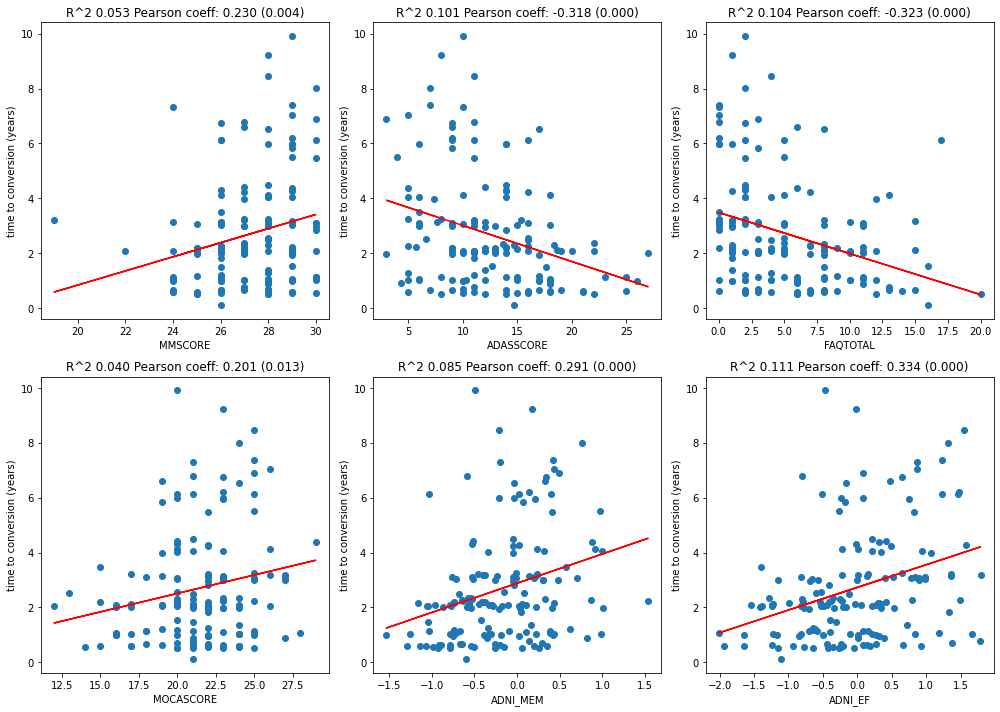

In [20]:
# Explore relationship between significant figures and time to conversion
plt.figure(figsize=(14,10))
for i, f in enumerate(significant_features):
    plt.subplot(2, 3, i+1)
    feature = features_mci2ad[:, f]
    LR_mci2ad = LinearRegression()
    LR_mci2ad.fit(feature.reshape(-1, 1), times.reshape(-1, 1))
    predicted_times = LR_mci2ad.predict(feature.reshape(-1, 1))
 
    # predicted values
    plt.plot(feature, predicted_times, color='r')
    plt.scatter(feature, times)
    plt.xlabel(features[f])
    plt.ylabel('time to conversion (years)')
    
    # add metrics
    r2 = metrics.r2_score(times, predicted_times)
    pearson_coeff, pval = pearsonr(times, feature)
    plt.title('R^2 %.3f Pearson coeff: %.3f (%.3f)' % (r2, pearson_coeff, pval))    

plt.tight_layout()
plt.show()

All neuropsych tests are well correlated with time to conversion, however this correlation is not as strong as with our neuropsych brainAge delta.